In [71]:
import pandas as pd
import numpy as np
from utils import demandPredictor

class Home():
    # constant attribute
    GRID_LIMIT = 0.5
    BATTERY_CONST = 12.
    UNIT_PRICE = [0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5]
    SELL_PRICE = 0.3
    CHARGE_RATE = 0.5
    
    def __init__(self, battery_const=12., battery_equipped=False):
        self.battery = 0.
        self.battery_equipped = battery_equipped
        Home.BATTERY_CONST = battery_const
        self.result = None
        self.dic = {'low':[0., 0], 'mid':[0., 0], 'high':[0., 0]}
    
    def grid_limit_check(self, amount, use=True):
        # return 'PV to grid', 'reduce PV'
        if use:
            if amount > Home.GRID_LIMIT:
                #print(amount, Home.GRID_LIMIT)
                return Home.GRID_LIMIT, amount-Home.GRID_LIMIT
            return amount, 0
        return amount, 0
    
    def battery_is_empty(self):
        if self.battery_equipped:
            return (self.battery == 0.)
        return True
    
    def battery_is_full(self):
        if self.battery_equipped:
            return (self.battery == Home.BATTERY_CONST)
        return True
    
    def pricing(self, hour, amount):
        if 0 <= hour < 6:
            self.dic['low'][0] += (amount/4.)
        elif 6 <= hour < 16:
            self.dic['mid'][0] += (amount/4.)
        else:
            self.dic['high'][0] += (amount/4.)
            
        if amount < 0:
            # sell to grid
            return amount * Home.SELL_PRICE / 4.
        else:
            # buy from grid
            return amount * Home.UNIT_PRICE[hour] / 4.
        
    def battery_auto_charge(self, demand_pre, demand_used, df, autocharge=False):
        if autocharge:
            # battery is not full
            if not self.battery_is_full():
                if demand_pre - demand_used - self.battery > 0:
                    # still need more electricity
                    if demand_pre - demand_used > Home.BATTERY_CONST - self.battery:
                        df.at[t, 'from_grid'] += Home.CHARGE_RATE
                        self.battery += Home.CHARGE_RATE
                    else:
                        df.at[t, 'from_grid'] += (Home.BATTERY_CONST - self.battery)
                        self.battery += (Home.BATTERY_CONST - self.battery)          

    def simuate(self, data):
        data['from_grid'] = ""
        data['sell_to_grid'] = ""
        data['battery_stat'] = ""
        data['cost'] = ""
        data['revenue'] = ""
        data['reduce'] = ""
        for t, row in data.iterrows():
            # check demand and PV
            deficit = (row['demand'] - row['solar'])/4.
            if deficit > 0:
                # grid or battery involved
                if self.battery_is_empty():
                    # grid involved
                    data.at[t, 'from_grid'] = deficit
                elif deficit > self.battery:
                    # both grid and battery involved
                    data.at[t, 'from_grid'] = deficit - self.battery
                    self.battery = 0 # from battery
                else:
                    # battery involved
                    self.battery -= deficit
                    data.at[t, 'from_grid'] = 0
                data.at[t, 'sell_to_grid'] = 0
                data.at[t, 'reduce'] = 0
            else:
                # charge by PV
                if self.battery_is_full():
                    # sell pv electricity to grid
                    extra = (-1)*deficit
                    extra, reduce = self.grid_limit_check((-1)*deficit)
                    data.at[t, 'sell_to_grid'] = extra
                    data.at[t, 'reduce'] = reduce
                elif self.battery + ((-1)*deficit) > Home.BATTERY_CONST:
                    # charge part of PV and sell part of PV
                    extra = self.battery + ((-1)*deficit) - Home.BATTERY_CONST
                    extra, reduce = self.grid_limit_check(extra)
                    self.battery = Home.BATTERY_CONST
                    data.at[t, 'sell_to_grid'] = extra
                    data.at[t, 'reduce'] = reduce
                else:
                    # charge
                    self.battery += ((-1)*deficit)
                    data.at[t, 'sell_to_grid'] = 0
                    data.at[t, 'reduce'] = 0
                data.at[t, 'from_grid'] = 0
            data.at[t, 'battery_stat'] = self.battery
        
        
        self.battery_auto_charge(demand_pre, demand_used, df, autocharge=True)
        self.result = data
        self.cost_calculate()
        self.revenue_calculate()
        
    def cost_calculate(self):
        for index, row in self.result.iterrows():
            self.result.at[index, 'cost'] = self.pricing(int(row['DateTime'].split(' ')[1].split(':')[0]), row['from_grid'])
        
    def revenue_calculate(self):
        for index, row in self.result.iterrows():
            self.result.at[index, 'revenue'] = self.pricing(int(row['DateTime'].split(' ')[1].split(':')[0]), row['sell_to_grid'])    
     
    def total_bill(self):
        date = ''
        total = 0.
        totals = []
        for index, row in self.result.iterrows():
            if date != row['DateTime'].split(' ')[0]:
                totals.append(total)
                total = 0
                date = row['DateTime'].split(' ')[0]
            total += (row['cost']-row['revenue'])
        totals.append(total)
        totals = totals[1:]
        return totals
    
    def show_usage(self):
        total = self.dic['low'][0] + self.dic['mid'][0] + self.dic['high'][0]
        print('total: {:.2f}, low: {:.2f}%, mid: {:.2f}%, high: {:.2f}%'.format(total, 100*self.dic['low'][0]/total, 100*self.dic['mid'][0]/total, 100*self.dic['high'][0]/total))
    
    def show_result(self, start=0, end=0):
        if start == end:
            print(self.result[:])
        else:
            print(self.result[start:end])

In [72]:
demand_test = pd.read_csv('../Data/electricity/test_electricity.csv')

demands = []
for i, row in demand_test.iterrows():
    if row['grid'] < 0:
        demands.append(row['solar'] - ((-1)*row['grid']))
    else:
        demands.append(row['grid']+row['solar'])
demand_test['demand'] = demands

test1, test2 = demand_test.loc[:], demand_test.loc[:]

home_with_battery = Home(battery_equipped=True)
home_no_battery = Home(battery_equipped=False)
home_with_battery.simuate(test1)
home_no_battery.simuate(test2)

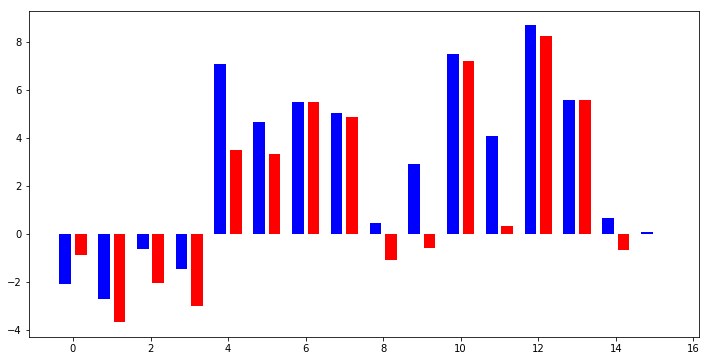

Without Battery => 	total bill: 94.09, revenue: 48.62, total: 45.47
total: 82.30, low: 16.20%, mid: 44.19%, high: 39.61%

With Battery    => 	total bill: 43.97, revenue: 17.26, total: 26.71
total: 36.39, low: 22.56%, mid: 36.63%, high: 40.81%


In [73]:
import matplotlib.pyplot as plt

X = np.arange(16)
plt.figure(figsize=(12, 6))
plt.bar(X-0.2, home_no_battery.total_bill(), color='b', width=0.3)
plt.bar(X+0.2, home_with_battery.total_bill(), color='r', width=0.3)
plt.show()
print('Without Battery => \ttotal bill: {:.2f}, revenue: {:.2f}, total: {:.2f}'.format(sum(home_no_battery.result['cost']), sum(home_no_battery.result['revenue']), sum(home_no_battery.result['cost'])-sum(home_no_battery.result['revenue'])))
home_no_battery.show_usage()
print('')
print('With Battery    => \ttotal bill: {:.2f}, revenue: {:.2f}, total: {:.2f}'.format(sum(home_with_battery.result['cost']), sum(home_with_battery.result['revenue']), sum(home_with_battery.result['cost'])-sum(home_with_battery.result['revenue'])))
home_with_battery.show_usage()

In [76]:
demand_t = pd.read_csv('../Data/electricity/test_electricity.csv')

demands = []
for i, row in demand_t.iterrows():
    if row['grid'] < 0:
        demands.append(row['solar'] - ((-1)*row['grid']))
    else:
        demands.append(row['grid']+row['solar'])
demand_t['demand'] = demands

test = demand_t.iloc[:]
total_records = []
cost_records = []
rev_records = []
reduce_records = []
for bc in range(0, 30, 2):
    home = Home(bc, battery_equipped=True)
    home.simuate(test)
    cost_records.append(sum(home.result['cost']))
    rev_records.append(sum(home.result['revenue']))     
    total_records.append(sum(home.result['cost'])-sum(home.result['revenue']))
    reduce_records.append(sum(home.result['reduce']))
    print(bc, end='\r')

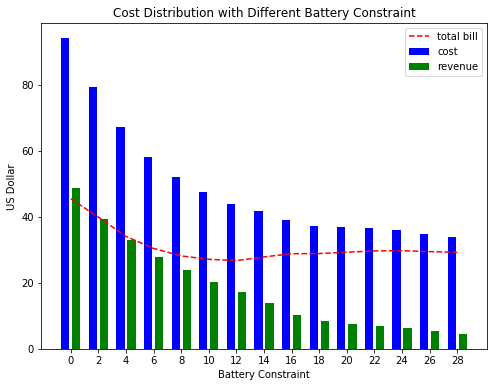

[45.46631250000006,
 39.86218750000005,
 34.04184374999998,
 30.402062500000003,
 28.13459374999999,
 27.104749999999953,
 26.706437499999943,
 27.838374999999964,
 28.795406249999978,
 28.855812499999985,
 29.248187499999986,
 29.65771874999999,
 29.71503125,
 29.443031249999976,
 29.207499999999975]

In [83]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot([str(i) for i in range(0, 30, 2)], total_records, label='total bill', linestyle="--", color='r')
X = np.arange(15)
plt.xlabel('Battery Constraint')
plt.ylabel('US Dollar')
plt.bar(X-0.2, cost_records, color='b', label='cost', width=0.3)
plt.bar(X+0.2, rev_records, color='g', label='revenue', width=0.3)
#plt.bar(X+0.2, reduce_records, color='r', label='reduce', width=0.15)
plt.legend(loc='upper right')
plt.title('Cost Distribution with Different Battery Constraint')
plt.show()
total_records